In [1]:
using Distributed
addprocs(44);

In [2]:
using pulse_input_DDM

In [3]:
path = "/usr/people/briandd/Projects/neural_DDM_analysis/data/hanks_data_sessions"

"/usr/people/briandd/Projects/neural_DDM_analysis/data/hanks_data_sessions"

In [ ]:
#ratnames = ["B068","T034","T036","T063","T030"] #FOF
#ratnames = ["T035","T011","B053"] PPC
#ratnames = ["T080","T103","E021"] #STR

In [4]:
region, rat = "FOF", "T036"

("FOF", "T036")

In [6]:
sessions = filter(x->occursin(rat,x), readdir(path))

12-element Array{String,1}:
 "T036_154154.mat"
 "T036_154291.mat"
 "T036_154448.mat"
 "T036_154991.mat"
 "T036_155124.mat"
 "T036_155247.mat"
 "T036_155840.mat"
 "T036_157201.mat"
 "T036_157357.mat"
 "T036_157507.mat"
 "T036_168499.mat"
 "T036_168627.mat"

In [7]:
output = load.(joinpath.(path, sessions), false, delay=0.05);

In [8]:
data = getindex.(output, 1)
μ_rnt = getindex.(output, 2);
μ_t = getindex.(output, 3);

In [9]:
f, ncells, ntrials, nparams = "Sigmoid", map(x-> x[1].ncells, data), length.(data), 4

("Sigmoid", [1, 1, 1, 2, 2, 1, 2, 3, 3, 3, 3, 4], [361, 329, 333, 452, 365, 324, 252, 410, 311, 389, 339, 431], 4)

In [10]:
θy0 = vcat(vcat(initialize_θy.(data, f)...)...);

In [11]:
fit=vcat(trues(dimz), trues(sum(ncells)*nparams))
x0=vcat([0.1, 12., -2., 10., 1., 0.4, 0.008], θy0);

In [12]:
options = neuraloptions(ncells=ncells, x0=x0, fit=fit, nparams=nparams, f=f);

In [13]:
n = 53

53

In [ ]:
model, = optimize(data, options, n);

Fminbox
-------
Initial mu = 0.0410648

Fminbox iteration 1
-------------------
Calling inner optimizer with mu = 0.0410648

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     1.648532e+05     9.058753e+02
 * time: 7.200241088867188e-5
     1     1.648278e+05     9.518884e+02
 * time: 36.022538900375366
     2     1.603926e+05     3.336813e+02
 * time: 72.49156999588013
     3     1.592809e+05     1.067008e+04
 * time: 107.98569893836975
     4     1.550843e+05     7.502592e+02
 * time: 143.6415240764618
     5     1.543860e+05     3.773201e+03
 * time: 179.22385692596436
     6     1.533793e+05     4.904848e+03
 * time: 214.86327004432678
     7     1.525005e+05     4.379306e+03
 * time: 250.8194921016693
     8     1.515880e+05     2.838319e+03
 * time: 286.682893037796
     9     1.499387e+05     1.589640e+03
 * time: 322.3897030353546
    10     1.492570e+05     1.484861e+03
 * time: 358.64986395835876
    11     1.483751e+05     1.0376

In [103]:
model.θ.θz

θz{Float64}
  σ2_i: Float64 0.1
  B: Float64 15.609195616893729
  λ: Float64 -0.7870366177993708
  σ2_a: Float64 3.804396706475496
  σ2_s: Float64 2.4999987856246433
  ϕ: Float64 0.22964878319498255
  τ_ϕ: Float64 0.43144249342595653


## Sample rates

In [195]:
nconds = 2

2

In [196]:
output = pulse_input_DDM.process_spike_data.(μ_rnt, data, ncells; nconds=nconds);

μ_ct = getindex.(output, 1)
σ_ct = getindex.(output, 2);

In [197]:
#μ_λ, μ_c_λ = pulse_input_DDM.synthetic_λ(model.θ, data; num_samples=100, nconds=nconds);
μ_λ, μ_c_λ = pulse_input_DDM.synthetic_λ(θ1, data; num_samples=100, nconds=nconds);

In [198]:
using PyPlot

In [199]:
dt = 1e-2

0.01

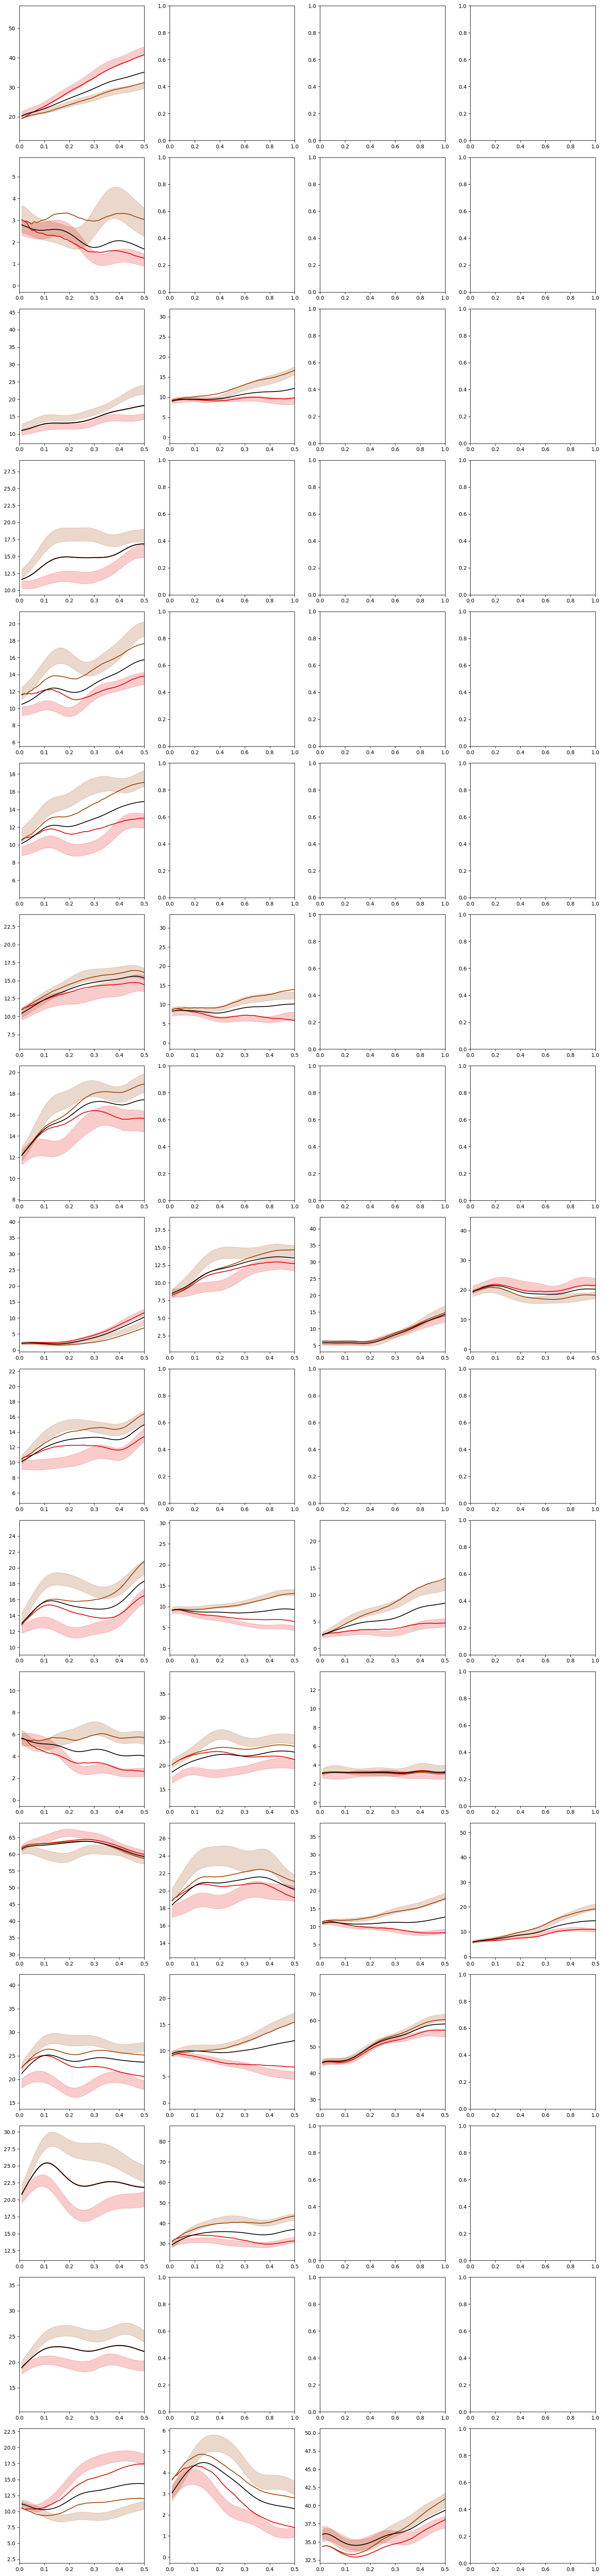

In [200]:
num_rows, num_cols = length(data), maximum(map(x-> x[1].ncells, data))
fig, ax = subplots(num_rows, num_cols, figsize=(4*maximum(map(x-> x[1].ncells, data)), 4*length(data)))
my_colors = ["#E50000","#9F3F00","#5A7F00","#15BF00"]
#PPC colors = ["#1822A0","#5D4A7A","#A37354","#E99C2F"]
#STR colors = ["#A01892","#B85C71","#D0A150","#E9E62F"]

for i in 1:num_rows
        
    for j in 1:data[i][1].ncells             
        for k = 1:nconds   

            ax[i,j].fill_between((1:length(μ_ct[i][j][k]))*dt,
                μ_ct[i][j][k] + σ_ct[i][j][k],
                μ_ct[i][j][k] - σ_ct[i][j][k],
                alpha=0.2, color=my_colors[k])

            ax[i,j].plot((1:length(μ_c_λ[i][j][k]))*dt,
                μ_c_λ[i][j][k], color=my_colors[k])                                     

            ax[i,j].set_xlim((0, 0.5))
                        
        end   
        
        ax[i,j].plot((1:length(μ_t[i][j]))*dt,
            μ_t[i][j], color="black")

    end
    
end

tight_layout() 

In [201]:
#LL_ML = loglikelihood(model.θ, data, n)
LL_ML = loglikelihood(θ1, data, n)

-319602.810844885

In [202]:
#LL_null = mapreduce((data,θy)-> mapreduce(data-> mapreduce(n->
#    pulse_input_DDM.neural_null(data.spikes[n], θy[n]([0.], data.input_data.λ0[n]), dt),
#        +, 1:data.ncells), +, data), +, data, model.θ.θy)

LL_null = mapreduce((data,θy)-> mapreduce(data-> mapreduce(n->
    pulse_input_DDM.neural_null(data.spikes[n], θy[n]([0.], data.input_data.λ0[n]), dt),
        +, 1:data.ncells), +, data), +, data, θ1.θy)

-323459.1310329336

In [203]:
LL_ML - LL_null

3856.3201880485867

In [204]:
SSx(x, nT) = sum(sum.(map(x-> x[1:nT].^2, vcat(vcat((x)...)...)))) 

SSx (generic function with 1 method)

In [205]:
1 - SSx(μ_c_λ - μ_ct, 40)/SSx(μ_ct, 40)

0.9947733615093493

### Compute Hessian
Blah blah blah

In [89]:
H = Hessian(model, n)
CI, HPSD = CIs(H);

In [90]:
CI

27-element Array{Float64,1}:
   0.9284929824029614 
  11.998094812325082  
   1.161288516355326  
  88.49945501991355   
   4.88521248060448   
   0.32751549418862425
   0.2801408388947553 
   6.855693181632444  
 192.25056343022763   
   0.6438021180466876 
   2.861207596260821  
   5.730096350002755  
  44.31095348585352   
   ⋮                  
   6.439857980334619  
  81.3590268503824    
   0.472385112600868  
   0.8808063507659961 
  10.638895596704323  
 173.09023196525192   
   0.48628759839614893
   1.9840124738604812 
   0.6614403190913544 
  18.56118344249491   
   4.295551804942658  
   5.661163324196894  